In [1]:
!git clone --depth=1 https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
!pip install filterpy

Cloning into 'Kalman-and-Bayesian-Filters-in-Python'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 170 (delta 5), reused 90 (delta 2), pack-reused 0
Receiving objects: 100% (170/170), 20.11 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (5/5), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=31e64efc078526fdf16255e8d14ce48919c5f199918df18f6696f0ce31375541
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [2]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python


In [3]:
#format the book
import book_format
book_format.set_style()

In [4]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book


In [5]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [6]:
hallway = np.array([1,1,0,0,0,0,0,0,1,0])

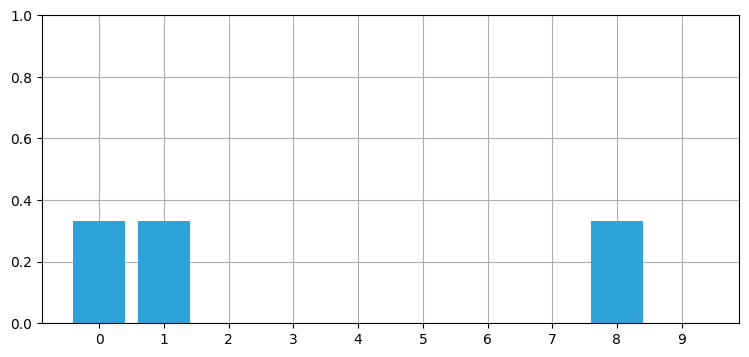

In [7]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3,1/3,0,0,0,0,0,0,1/3,0])
book_plots.bar_plot(belief)

In [8]:
belief = hallway *(1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


In [11]:
belief = np.array([0., 1., 0., 0.,0., 0.,0., 0.,0., 0., ])

信念: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
和= 1.6000000000000003


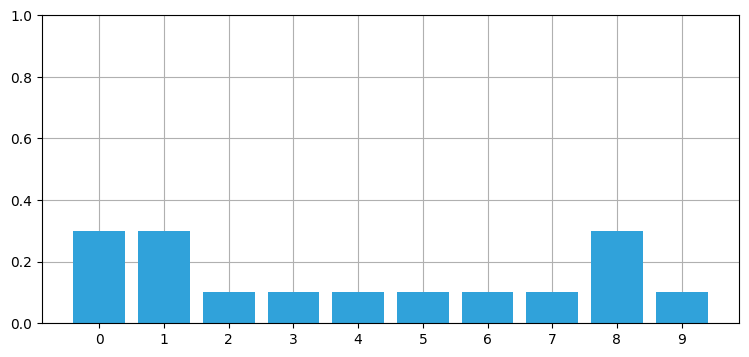

In [12]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale
            
belief = np.array([0.1]*10)
reading = 1   # 1 = 「ドア」
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('信念:', belief)
print('和=', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

In [13]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

In [14]:
from filterpy.discrete_bayes import normalize
normalize(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

In [15]:
hallway ==1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

和= 1.0
ドアの確率= 0.1875
壁の確率= 0.06249999999999999


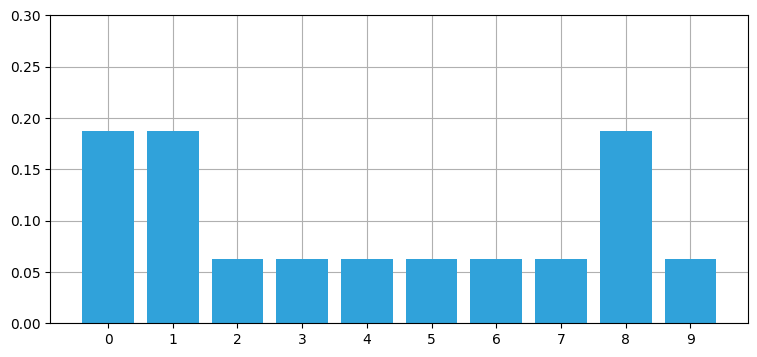

In [16]:
def scaled_update(hall, belief, z, z_prob):
    scale =z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)
    
belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('和=', sum(belief))
print('ドアの確率=', belief[0])
print('壁の確率=', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

In [17]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

In [18]:
def update(likelihood, prior):
    return normalize(likelihood * prior)

In [19]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """計測値が廊下の各位置にマッチする尤度を計算する。"""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8
        
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1]*10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])